# Run

This notebook creates the neighbourhood aggregates from the preprocessed data.

## Settings

In [1]:
dist_folder = '../tmp/dist' # stores outputs
data_sources_file = 'data.csv'
study_area_dataset = 'toronto' # bbox will be used as study area
force = False # whether to force processing
genstats = ['sum', 'mean', 'min', 'max', 'median', 'var', 'skew', 'std', 'sem', 'mad'] # name of gen stats from pandas to agg numeric values
genstats_quantiles = True # whether to include quantiles in gen stats or not
grid_sizes = [10, 20, 40, 60, 80, 100]

## Libraries

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import re

from datetime import datetime, timedelta
from IPython.display import display, HTML
from numbers import Number
from pathlib import Path
from shapely.geometry import box, Point
from time import time

## Classes

In [3]:
# For timing processes and displaying processing messages
class Timer:
    
    def __init__(self, name, process_name=None, start_prefix=None, end_prefix=None):
        self.name = name
        self.process_name = process_name
        self.start_prefix = start_prefix if start_prefix else 'Loading' if process_name.startswith('already') else 'Processing'
        self.end_prefix = end_prefix if end_prefix else 'Loaded' if process_name.startswith('already') else 'Processed'
    
    def start(self):
        self.start = time()
        self.start_dt = datetime.now()
        print(f'{self.start_prefix} {self.name} - {self.process_name} ({self.start_dt})...')
    
    def end(self):
        self.end = time()
        self.end_dt = datetime.now()
        self.elapsed = str(timedelta(seconds=self.end - self.start))
        print(f'{self.end_prefix} {self.name} - {self.process_name} ({self.end_dt}) [Elapsed: {self.elapsed}]')

## Functions

### Data Functions

In [4]:
# Formats human readable sizes in bytes
# https://stackoverflow.com/questions/1094841/get-human-readable-version-of-file-size
def format_size(num, suffix="B"):
    for unit in ["", "Ki", "Mi", "Gi", "Ti", "Pi", "Ei", "Zi"]:
        if abs(num) < 1024.0:
            return f"{num:3.1f} {unit}{suffix}"
        num /= 1024.0
    return f"{num:.1f} Yi{suffix}"

# Format cols to be lowercase with underscores and alphanumerics only
def format_cols(df):
    out = df
    out = out.rename(str.lower, axis='columns') # lowercase
    out.columns = [re.sub('[^A-Za-z0-9 ]+', '', c) for c in out.columns] # remove non alphanumeric
    out.columns = [' '.join(c.split()).replace(' ', '_') for c in out.columns] # remove extra whitespace, replace w/ underscore
    return out

# Extracts file info for summary
def file_info(file):
    stats = Path(file).stat()
    modified = datetime.fromtimestamp(stats.st_mtime)
    created = datetime.fromtimestamp(stats.st_birthtime)
    size = format_size(stats.st_size)
    out = {'created': created, 'modified': modified, 'size': size}
    return out

# Get basic info on a pandas dataframe
def df_info(df, name):
    memory = format_size(df.memory_usage().sum())
    cols = len(df.columns)
    rows = len(df)
    geometry = str(pd.unique(df.geometry.geom_type)) if 'geometry' in df else None
    out = {
        'dataset': name,
        'columns': cols,
        'rows': rows,
        'memory_usage': memory,
        'geometry': geometry
    }
    return out

# Read csv, shp, or geojson file into pandas or geopandas
def read_data(file, *args, **kwargs):
    path = Path(file)
    ext = path.suffix if path.suffix != '.zip' else path.suffixes[0]
    ext = ext.lower()
    if ext == '.csv':
        out = pd.read_csv(file, *args, **kwargs)
    elif ext in ['.geojson', '.shp']:
        out = gpd.read_file(file, *args, **kwargs)
    else:
        raise ValueError('File format not supported')
    return out

# Read processed dataset in dist folder
def read_clean_dataset(dataset, folder='../dist', *args, **kwargs):
    file = Path(f'{folder}/clean-datasets/{dataset}.geojson')
    out = read_data(file, *args, **kwargs)
    return out

# Check if dataset is processed in dist folder
def dataset_processed(dataset, folder='../dist'):
    file = Path(f'{folder}/clean-datasets/{dataset}.geojson')
    out = file.is_file()
    return out

# Save variable to csv files
def save_vars(gdf, size, dist_folder=dist_folder):
    for c in gdf.columns:
        if c != 'geometry':
            v = gdf[c]
            v.to_csv(f'{dist_folder}/by-variable-{size}/{c}.csv')

### Grid Function

In [5]:
# Generate geogrids using a bounding box
# Edited from James Brennan's code
# https://james-brennan.github.io/posts/fast_gridding_geopandas/
def gen_grid(bbox, size=100):
    
    # Get bounds of bbox
    xmin, ymin, xmax, ymax = bbox.total_bounds
    crs = bbox.crs
    
    # Calculate cell size based on num of cells
    cell_size = (xmax-xmin)/size
    
    # Generate cells
    grid_cells = []
    for x0 in np.arange(xmin, xmax+cell_size, cell_size):
        for y0 in np.arange(ymin, ymax+cell_size, cell_size):
            x1 = x0-cell_size
            y1 = y0+cell_size
            grid_cells.append(box(x0, y0, x1, y1))
    
    # Create geodf and return
    out = gpd.GeoDataFrame(
        grid_cells,
        columns=['geometry'],
        crs=crs
    )
    out.index = list(out.index)
    return out

### Aggregation Functions

In [6]:
# Calculates the mode for a series
def mode(x):
    out = x.map(str).value_counts().index[0]
    return out

# 25 per quantile
def quantile25(df):
    out = df.quantile(0.25)
    return out

# 50 per quantile
def quantile50(df):
    out = df.quantile(0.5)
    return out

# 75 per quantile
def quantile75(df):
    out = df.quantile(0.75)
    return out

# Return a func for getting geom length aggs
def glen(agg):
    def out(x):
        return getattr(x.length, agg)()
    return out

# Calculates the counts of unique values given all possible values
def ucounts(df, c, possible, round=False):
    
    # Get counts in df
    counts = df[c].value_counts().to_dict()
    
    # Round numeric values
    if round:
        possible = [int(k) if isinstance(k, Number) else k for k in possible]
        counts = {int(k) if isinstance(k, Number) else k: v for k,v in counts.items()}
    
    # Apply counts as dict with possible values
    possible = [str(k) for k in possible]
    out = {k:[0] for k in possible}
    for k, v in counts.items():
        out[str(k)] = [v]
    out = pd.DataFrame(out)
    return out

### Metric Functions

In [7]:
# Calculate line sinuosity (how curved lines are)
def lsin(geom):
    
    # Calculate straight length
    start = gpd.GeoSeries([Point(g.coords[0]) for g in geom])
    end = gpd.GeoSeries([Point(g.coords[-1]) for g in geom])
    straight_len = start.distance(end).reset_index(drop=True)
    
    # Calculate sin = actual / straight
    actual_len = geom.length.reset_index(drop=True)
    out = actual_len / straight_len
    return out

## Run

Create folders to store processed data:

In [9]:
# Create folders for clean and output data
Path(dist_folder).mkdir(parents=True, exist_ok=True)
Path(f'{dist_folder}/base-grids').mkdir(parents=True, exist_ok=True)
for size in grid_sizes:
    for f in [f'by-dataset-{size}', f'by-variable-{size}']:
        Path(f'{dist_folder}/{f}').mkdir(parents=True, exist_ok=True)

Read the study area dataset:

In [10]:
study_area = read_data(f'{dist_folder}/clean-datasets/{study_area_dataset}.geojson')

Track processing time for all datasets and procedures:

In [11]:
gtimer = Timer('all datasets', 'preprocessing')
gtimer.start()

Processing all datasets - preprocessing (2022-02-21 23:57:15.889907)...


Include quantiles in general statistics for aggregating numeric values during spatial binning:

In [12]:
if genstats_quantiles:
    genstats = genstats + [quantile25, quantile50, quantile75]

### Grid Creation

Create grids of various sizes for binning.

In [13]:
allgrids = {}
for size in grid_sizes:
    file = Path(f'{dist_folder}/base-grids/geogrid_to_{size}_base.geojson')
    if not file.is_file() or force:
        grid = gen_grid(study_area, size)
        grid.to_file(file)
        allgrids[str(size)] = grid
    else:
        allgrids[str(size)] = read_data(file)

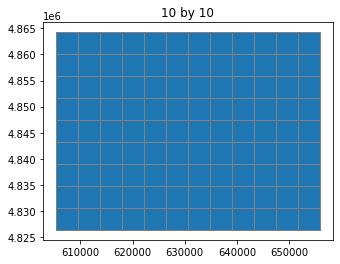

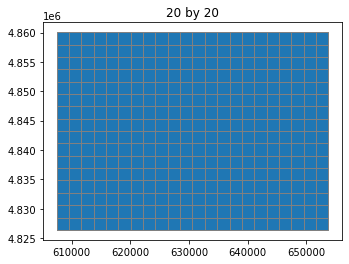

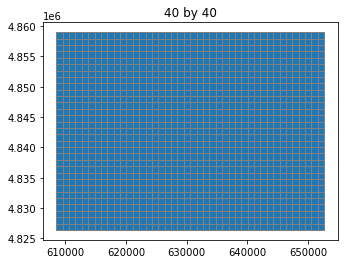

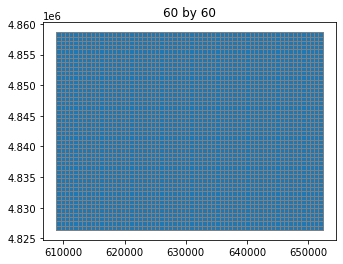

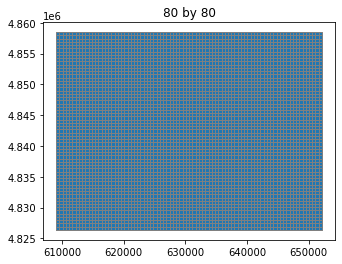

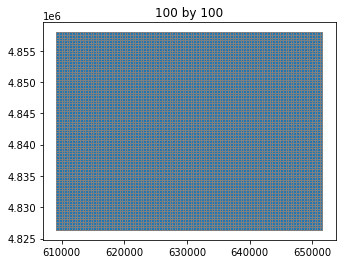

In [13]:
for size in allgrids:
    allgrids[size].plot(edgecolor='gray').set_title(f'{size} by {size}')

### Spatial Binning (Counts Only)

Spatially bin counted column values into each neighbourhood using the cleaned datasets.

In [14]:
to_count = [
    'autospeed_enforcement',
    'red_light_cams',
    'police',
    'ambulance',
    'fire_hydrants',
    'fire_stations',
    'renewables',
    'bicycle_parking',
    'transit_shelters',
    'wayfind',
    'litter',
    'art',
    'culture',
    'religious'
]
for size, grid in allgrids.items():
    
    for name in to_count:

        # Read data
        data = read_data(f'{dist_folder}/clean-datasets/{name}.geojson')

        # Only process if dataset file not created
        file = Path(f'{dist_folder}/by-dataset-{size}/geogrid_to_{name}.geojson')
        if not file.is_file() or force:

            # Start processing
            timer = Timer(f'{name} ({size})', 'spatial binning')
            timer.start()

            # Spatial join to grid
            join = grid.sjoin(data, predicate='intersects')

            # Agg counts
            counts = join.groupby(join.index).size()
            counts_col = f'{name}_count'
            counts.name = counts_col

            # Add counts to grid
            gdf = grid.join(counts)
            gdf[counts_col] = gdf[counts_col].fillna(0)

            # Save by dataset
            gdf.to_file(file)

            # Save by variable
            save_vars(gdf, size)

            # End processing
            timer.end()

        else:
            print(f'Skipping {file} - already binned ({datetime.now()})')

Processing autospeed_enforcement (10) - spatial binning (2022-02-18 23:44:58.372847)...
Processed autospeed_enforcement (10) - spatial binning (2022-02-18 23:44:58.401395) [Elapsed: 0:00:00.028547]
Processing red_light_cams (10) - spatial binning (2022-02-18 23:44:58.410639)...
Processed red_light_cams (10) - spatial binning (2022-02-18 23:44:58.429622) [Elapsed: 0:00:00.018983]
Processing police (10) - spatial binning (2022-02-18 23:44:58.434617)...
Processed police (10) - spatial binning (2022-02-18 23:44:58.453777) [Elapsed: 0:00:00.019160]
Processing ambulance (10) - spatial binning (2022-02-18 23:44:58.459255)...
Processed ambulance (10) - spatial binning (2022-02-18 23:44:58.478419) [Elapsed: 0:00:00.019164]


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future

Processing fire_hydrants (10) - spatial binning (2022-02-18 23:44:59.372673)...
Processed fire_hydrants (10) - spatial binning (2022-02-18 23:44:59.417418) [Elapsed: 0:00:00.044745]
Processing fire_stations (10) - spatial binning (2022-02-18 23:44:59.432369)...
Processed fire_stations (10) - spatial binning (2022-02-18 23:44:59.452157) [Elapsed: 0:00:00.019788]
Processing renewables (10) - spatial binning (2022-02-18 23:44:59.459284)...
Processed renewables (10) - spatial binning (2022-02-18 23:44:59.479371) [Elapsed: 0:00:00.020088]


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processing bicycle_parking (10) - spatial binning (2022-02-18 23:44:59.858944)...
Processed bicycle_parking (10) - spatial binning (2022-02-18 23:44:59.887177) [Elapsed: 0:00:00.028233]
Processing transit_shelters (10) - spatial binning (2022-02-18 23:45:00.011262)...
Processed transit_shelters (10) - spatial binning (2022-02-18 23:45:00.033827) [Elapsed: 0:00:00.022565]
Processing wayfind (10) - spatial binning (2022-02-18 23:45:00.046224)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed wayfind (10) - spatial binning (2022-02-18 23:45:00.065818) [Elapsed: 0:00:00.019594]
Processing litter (10) - spatial binning (2022-02-18 23:45:00.277311)...
Processed litter (10) - spatial binning (2022-02-18 23:45:00.302418) [Elapsed: 0:00:00.025107]


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future

Processing art (10) - spatial binning (2022-02-18 23:45:00.317835)...
Processed art (10) - spatial binning (2022-02-18 23:45:00.338532) [Elapsed: 0:00:00.020697]
Processing culture (10) - spatial binning (2022-02-18 23:45:00.360921)...
Processed culture (10) - spatial binning (2022-02-18 23:45:00.379939) [Elapsed: 0:00:00.019017]
Processing religious (10) - spatial binning (2022-02-18 23:45:00.412367)...
Processed religious (10) - spatial binning (2022-02-18 23:45:00.431454) [Elapsed: 0:00:00.019087]
Processing autospeed_enforcement (20) - spatial binning (2022-02-18 23:45:00.437653)...
Processed autospeed_enforcement (20) - spatial binning (2022-02-18 23:45:00.478434) [Elapsed: 0:00:00.040779]
Processing red_light_cams (20) - spatial binning (2022-02-18 23:45:00.486392)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed red_light_cams (20) - spatial binning (2022-02-18 23:45:00.547830) [Elapsed: 0:00:00.061435]
Processing police (20) - spatial binning (2022-02-18 23:45:00.553282)...
Processed police (20) - spatial binning (2022-02-18 23:45:00.595426) [Elapsed: 0:00:00.042143]
Processing ambulance (20) - spatial binning (2022-02-18 23:45:00.600595)...
Processed ambulance (20) - spatial binning (2022-02-18 23:45:00.641392) [Elapsed: 0:00:00.040794]
Processing fire_hydrants (20) - spatial binning (2022-02-18 23:45:01.553828)...
Processed fire_hydrants (20) - spatial binning (2022-02-18 23:45:01.618690) [Elapsed: 0:00:00.064862]
Processing fire_stations (20) - spatial binning (2022-02-18 23:45:01.633874)...
Processed fire_stations (20) - spatial binning (2022-02-18 23:45:01.675976) [Elapsed: 0:00:00.042103]
Processing renewables (20) - spatial binning (2022-02-18 23:45:01.682229)...
Processed renewables (20) - spatial binning (2022-02-18 23:45:01.723875) [Elapsed: 0:00:00.041645]


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processing bicycle_parking (20) - spatial binning (2022-02-18 23:45:02.078779)...
Processed bicycle_parking (20) - spatial binning (2022-02-18 23:45:02.130358) [Elapsed: 0:00:00.051579]
Processing transit_shelters (20) - spatial binning (2022-02-18 23:45:02.255711)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed transit_shelters (20) - spatial binning (2022-02-18 23:45:02.303530) [Elapsed: 0:00:00.047819]
Processing wayfind (20) - spatial binning (2022-02-18 23:45:02.317401)...
Processed wayfind (20) - spatial binning (2022-02-18 23:45:02.361527) [Elapsed: 0:00:00.044126]


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processing litter (20) - spatial binning (2022-02-18 23:45:02.575882)...
Processed litter (20) - spatial binning (2022-02-18 23:45:02.623877) [Elapsed: 0:00:00.047996]
Processing art (20) - spatial binning (2022-02-18 23:45:02.638658)...
Processed art (20) - spatial binning (2022-02-18 23:45:02.680250) [Elapsed: 0:00:00.041592]
Processing culture (20) - spatial binning (2022-02-18 23:45:02.712596)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed culture (20) - spatial binning (2022-02-18 23:45:02.791956) [Elapsed: 0:00:00.079362]
Processing religious (20) - spatial binning (2022-02-18 23:45:02.865396)...
Processed religious (20) - spatial binning (2022-02-18 23:45:02.912116) [Elapsed: 0:00:00.046720]
Processing autospeed_enforcement (40) - spatial binning (2022-02-18 23:45:02.919914)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed autospeed_enforcement (40) - spatial binning (2022-02-18 23:45:03.058106) [Elapsed: 0:00:00.138178]
Processing red_light_cams (40) - spatial binning (2022-02-18 23:45:03.067289)...
Processed red_light_cams (40) - spatial binning (2022-02-18 23:45:03.199193) [Elapsed: 0:00:00.131904]
Processing police (40) - spatial binning (2022-02-18 23:45:03.204322)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed police (40) - spatial binning (2022-02-18 23:45:03.332955) [Elapsed: 0:00:00.128631]
Processing ambulance (40) - spatial binning (2022-02-18 23:45:03.338624)...
Processed ambulance (40) - spatial binning (2022-02-18 23:45:03.474669) [Elapsed: 0:00:00.136044]
Processing fire_hydrants (40) - spatial binning (2022-02-18 23:45:04.362098)...
Processed fire_hydrants (40) - spatial binning (2022-02-18 23:45:04.514426) [Elapsed: 0:00:00.152329]
Processing fire_stations (40) - spatial binning (2022-02-18 23:45:04.529387)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed fire_stations (40) - spatial binning (2022-02-18 23:45:04.661306) [Elapsed: 0:00:00.131919]
Processing renewables (40) - spatial binning (2022-02-18 23:45:04.668085)...
Processed renewables (40) - spatial binning (2022-02-18 23:45:04.795511) [Elapsed: 0:00:00.127425]


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processing bicycle_parking (40) - spatial binning (2022-02-18 23:45:05.168080)...
Processed bicycle_parking (40) - spatial binning (2022-02-18 23:45:05.324306) [Elapsed: 0:00:00.156227]


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processing transit_shelters (40) - spatial binning (2022-02-18 23:45:05.452115)...
Processed transit_shelters (40) - spatial binning (2022-02-18 23:45:05.584810) [Elapsed: 0:00:00.132695]
Processing wayfind (40) - spatial binning (2022-02-18 23:45:05.597113)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed wayfind (40) - spatial binning (2022-02-18 23:45:05.727567) [Elapsed: 0:00:00.130453]
Processing litter (40) - spatial binning (2022-02-18 23:45:05.935003)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed litter (40) - spatial binning (2022-02-18 23:45:06.070894) [Elapsed: 0:00:00.135891]
Processing art (40) - spatial binning (2022-02-18 23:45:06.085468)...
Processed art (40) - spatial binning (2022-02-18 23:45:06.215027) [Elapsed: 0:00:00.129558]
Processing culture (40) - spatial binning (2022-02-18 23:45:06.237253)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed culture (40) - spatial binning (2022-02-18 23:45:06.367825) [Elapsed: 0:00:00.130571]
Processing religious (40) - spatial binning (2022-02-18 23:45:06.400134)...
Processed religious (40) - spatial binning (2022-02-18 23:45:06.529992) [Elapsed: 0:00:00.129857]
Processing autospeed_enforcement (60) - spatial binning (2022-02-18 23:45:06.536594)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed autospeed_enforcement (60) - spatial binning (2022-02-18 23:45:06.823039) [Elapsed: 0:00:00.286443]
Processing red_light_cams (60) - spatial binning (2022-02-18 23:45:06.832538)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed red_light_cams (60) - spatial binning (2022-02-18 23:45:07.114764) [Elapsed: 0:00:00.282226]
Processing police (60) - spatial binning (2022-02-18 23:45:07.120233)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed police (60) - spatial binning (2022-02-18 23:45:07.398299) [Elapsed: 0:00:00.278065]
Processing ambulance (60) - spatial binning (2022-02-18 23:45:07.403633)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed ambulance (60) - spatial binning (2022-02-18 23:45:07.680033) [Elapsed: 0:00:00.276399]
Processing fire_hydrants (60) - spatial binning (2022-02-18 23:45:08.592647)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed fire_hydrants (60) - spatial binning (2022-02-18 23:45:08.896150) [Elapsed: 0:00:00.303504]
Processing fire_stations (60) - spatial binning (2022-02-18 23:45:08.911746)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed fire_stations (60) - spatial binning (2022-02-18 23:45:09.183947) [Elapsed: 0:00:00.272202]
Processing renewables (60) - spatial binning (2022-02-18 23:45:09.190499)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed renewables (60) - spatial binning (2022-02-18 23:45:09.477509) [Elapsed: 0:00:00.287009]
Processing bicycle_parking (60) - spatial binning (2022-02-18 23:45:09.826017)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed bicycle_parking (60) - spatial binning (2022-02-18 23:45:10.126437) [Elapsed: 0:00:00.300421]
Processing transit_shelters (60) - spatial binning (2022-02-18 23:45:10.249626)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed transit_shelters (60) - spatial binning (2022-02-18 23:45:10.522320) [Elapsed: 0:00:00.272693]
Processing wayfind (60) - spatial binning (2022-02-18 23:45:10.534492)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed wayfind (60) - spatial binning (2022-02-18 23:45:10.819187) [Elapsed: 0:00:00.284696]
Processing litter (60) - spatial binning (2022-02-18 23:45:11.060940)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed litter (60) - spatial binning (2022-02-18 23:45:11.352683) [Elapsed: 0:00:00.291742]
Processing art (60) - spatial binning (2022-02-18 23:45:11.368261)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed art (60) - spatial binning (2022-02-18 23:45:11.642657) [Elapsed: 0:00:00.274396]
Processing culture (60) - spatial binning (2022-02-18 23:45:11.665036)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed culture (60) - spatial binning (2022-02-18 23:45:11.959900) [Elapsed: 0:00:00.294864]
Processing religious (60) - spatial binning (2022-02-18 23:45:11.992375)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed religious (60) - spatial binning (2022-02-18 23:45:12.267921) [Elapsed: 0:00:00.275546]
Processing autospeed_enforcement (80) - spatial binning (2022-02-18 23:45:12.274627)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed autospeed_enforcement (80) - spatial binning (2022-02-18 23:45:12.737866) [Elapsed: 0:00:00.463238]
Processing red_light_cams (80) - spatial binning (2022-02-18 23:45:12.746584)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed red_light_cams (80) - spatial binning (2022-02-18 23:45:13.238671) [Elapsed: 0:00:00.492086]
Processing police (80) - spatial binning (2022-02-18 23:45:13.244102)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed police (80) - spatial binning (2022-02-18 23:45:13.732900) [Elapsed: 0:00:00.488797]
Processing ambulance (80) - spatial binning (2022-02-18 23:45:13.738551)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed ambulance (80) - spatial binning (2022-02-18 23:45:14.238661) [Elapsed: 0:00:00.500110]
Processing fire_hydrants (80) - spatial binning (2022-02-18 23:45:15.107733)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed fire_hydrants (80) - spatial binning (2022-02-18 23:45:15.596867) [Elapsed: 0:00:00.489135]
Processing fire_stations (80) - spatial binning (2022-02-18 23:45:15.611793)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed fire_stations (80) - spatial binning (2022-02-18 23:45:16.100994) [Elapsed: 0:00:00.489201]
Processing renewables (80) - spatial binning (2022-02-18 23:45:16.107437)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed renewables (80) - spatial binning (2022-02-18 23:45:16.568844) [Elapsed: 0:00:00.461406]
Processing bicycle_parking (80) - spatial binning (2022-02-18 23:45:16.908321)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed bicycle_parking (80) - spatial binning (2022-02-18 23:45:17.380850) [Elapsed: 0:00:00.472528]
Processing transit_shelters (80) - spatial binning (2022-02-18 23:45:17.534083)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed transit_shelters (80) - spatial binning (2022-02-18 23:45:18.002845) [Elapsed: 0:00:00.468762]
Processing wayfind (80) - spatial binning (2022-02-18 23:45:18.015159)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed wayfind (80) - spatial binning (2022-02-18 23:45:18.479050) [Elapsed: 0:00:00.463892]
Processing litter (80) - spatial binning (2022-02-18 23:45:18.686782)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed litter (80) - spatial binning (2022-02-18 23:45:19.161721) [Elapsed: 0:00:00.474939]
Processing art (80) - spatial binning (2022-02-18 23:45:19.176734)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed art (80) - spatial binning (2022-02-18 23:45:19.680849) [Elapsed: 0:00:00.504115]
Processing culture (80) - spatial binning (2022-02-18 23:45:19.703612)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed culture (80) - spatial binning (2022-02-18 23:45:20.171869) [Elapsed: 0:00:00.468257]
Processing religious (80) - spatial binning (2022-02-18 23:45:20.204261)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed religious (80) - spatial binning (2022-02-18 23:45:20.668983) [Elapsed: 0:00:00.464721]
Processing autospeed_enforcement (100) - spatial binning (2022-02-18 23:45:20.676148)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed autospeed_enforcement (100) - spatial binning (2022-02-18 23:45:21.371347) [Elapsed: 0:00:00.695198]
Processing red_light_cams (100) - spatial binning (2022-02-18 23:45:21.379929)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed red_light_cams (100) - spatial binning (2022-02-18 23:45:22.093913) [Elapsed: 0:00:00.713983]
Processing police (100) - spatial binning (2022-02-18 23:45:22.099068)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed police (100) - spatial binning (2022-02-18 23:45:22.821703) [Elapsed: 0:00:00.722634]
Processing ambulance (100) - spatial binning (2022-02-18 23:45:22.827253)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed ambulance (100) - spatial binning (2022-02-18 23:45:23.519466) [Elapsed: 0:00:00.692211]
Processing fire_hydrants (100) - spatial binning (2022-02-18 23:45:24.382209)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed fire_hydrants (100) - spatial binning (2022-02-18 23:45:25.135613) [Elapsed: 0:00:00.753403]
Processing fire_stations (100) - spatial binning (2022-02-18 23:45:25.150849)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed fire_stations (100) - spatial binning (2022-02-18 23:45:25.842472) [Elapsed: 0:00:00.691623]
Processing renewables (100) - spatial binning (2022-02-18 23:45:25.849017)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed renewables (100) - spatial binning (2022-02-18 23:45:26.541934) [Elapsed: 0:00:00.692915]
Processing bicycle_parking (100) - spatial binning (2022-02-18 23:45:26.914233)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed bicycle_parking (100) - spatial binning (2022-02-18 23:45:27.618080) [Elapsed: 0:00:00.703846]
Processing transit_shelters (100) - spatial binning (2022-02-18 23:45:27.742238)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed transit_shelters (100) - spatial binning (2022-02-18 23:45:28.443300) [Elapsed: 0:00:00.701059]
Processing wayfind (100) - spatial binning (2022-02-18 23:45:28.455557)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed wayfind (100) - spatial binning (2022-02-18 23:45:29.149201) [Elapsed: 0:00:00.693643]
Processing litter (100) - spatial binning (2022-02-18 23:45:29.386217)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed litter (100) - spatial binning (2022-02-18 23:45:30.090407) [Elapsed: 0:00:00.704189]
Processing art (100) - spatial binning (2022-02-18 23:45:30.105091)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed art (100) - spatial binning (2022-02-18 23:45:30.799619) [Elapsed: 0:00:00.694527]
Processing culture (100) - spatial binning (2022-02-18 23:45:30.821837)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed culture (100) - spatial binning (2022-02-18 23:45:31.548900) [Elapsed: 0:00:00.727062]
Processing religious (100) - spatial binning (2022-02-18 23:45:31.581512)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed religious (100) - spatial binning (2022-02-18 23:45:32.274344) [Elapsed: 0:00:00.692831]


Preview a spatially binned count dataset:

In [15]:
preview = gpd.read_file(f'{dist_folder}/by-dataset-40/geogrid_to_autospeed_enforcement.geojson')
preview

,autospeed_enforcement_count,geometry
0,0.0,"POLYGON ((608501.620 4826386.931, 608501.620 4..."
1,0.0,"POLYGON ((608501.620 4827438.781, 608501.620 4..."
2,0.0,"POLYGON ((608501.620 4828490.631, 608501.620 4..."
3,0.0,"POLYGON ((608501.620 4829542.481, 608501.620 4..."
4,0.0,"POLYGON ((608501.620 4830594.330, 608501.620 4..."
...,...,...
1297,0.0,"POLYGON ((651627.463 4853735.027, 651627.463 4..."
1298,0.0,"POLYGON ((651627.463 4854786.877, 651627.463 4..."
1299,0.0,"POLYGON ((651627.463 4855838.726, 651627.463 4..."
1300,0.0,"POLYGON ((651627.463 4856890.576, 651627.463 4..."


<AxesSubplot:>

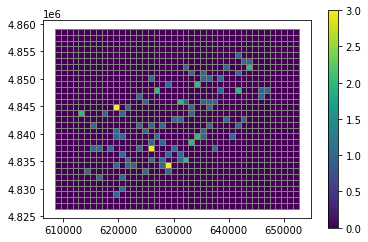

In [16]:
preview.plot(
    column='autospeed_enforcement_count',
    edgecolor='gray',
    legend=True
)

### Spatial Binning (Aggregates)

Spatially bin aggregate column values into each neighbourhood using the cleaned datasets.

#### centrelines

Bin centreline geometry calculations and features:

In [17]:
name = 'centrelines'
data = read_data(f'{dist_folder}/clean-datasets/{name}.geojson')

for size, grid in allgrids.items():
    
    # Only process if dataset file not created
    file = Path(f'{dist_folder}/by-dataset-{size}/geogrid_to_{name}.geojson')
    if not file.is_file() or force:

        # Start processing
        timer = Timer(f'{name} ({size})', 'spatial binning')
        timer.start()

        # Split lines at polygons using overlay
        overlay = gpd.overlay(
            data,
            grid,
            how='intersection'
        ).explode(index_parts=False)

        # Add sinuosity metric (how curved lines are)
        overlay.insert(
            len(overlay.columns) - 2, # insert before geometry
            'sin',
            lsin(overlay.geometry)
        )

        # Spatial join lines to each grid
        join = overlay.sjoin(grid, predicate='intersects')

        # Aggregate cols by grid
        group = join.groupby(join['index_right'])
        agg = group.agg({
            'centrelines_feature_code': [mode],
            'centrelines_oneway_dir_code': [mode],
            'geometry': [
                ('len_sum', glen('sum')),
                ('len_mean', glen('mean')),
                ('len_median', glen('median')),
                ('len_min', glen('min')),
                ('len_max', glen('max'))
            ],
            'sin': genstats
        })

        # Rename agg cols
        agg.columns = ['_'.join(c).strip().replace('geometry_', '') for c in agg.columns]
        agg.columns = [f'{name}_{c}' if not c.startswith(f'{name}_') else c for c in agg.columns]

        # Count freq
        freq = []
        for c in ['centrelines_feature_code', 'centrelines_oneway_dir_code']:

            # Get possible unique values in col
            possible = data[c].unique()

            # Count freq for each unique value
            f = group.apply(ucounts, c=c, possible=possible)

            # Rename freq cols
            f = format_cols(f)
            prefix = c.replace(f'{name}_', '')
            f.columns = [f'{name}_{prefix}_{c}_count' for c in f.columns]
            freq.append(f)

        # Combine count freq
        freq = pd.concat(freq, axis=1)
        freq.index = freq.index.get_level_values(0)

        # Add agg and freq to grid
        gdf = grid.join(agg)
        gdf = gdf.join(freq)

        # Save by dataset
        gdf.to_file(file)

        # Save by variable
        save_vars(gdf, size)

        # End processing
        timer.end()

    else:
        print(f'Skipping {file} - already binned ({datetime.now()})')

Processing centrelines (10) - spatial binning (2022-02-18 23:45:35.564267)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed centrelines (10) - spatial binning (2022-02-18 23:45:43.278542) [Elapsed: 0:00:07.714275]
Processing centrelines (20) - spatial binning (2022-02-18 23:45:43.278773)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed centrelines (20) - spatial binning (2022-02-18 23:45:51.848605) [Elapsed: 0:00:08.569830]
Processing centrelines (40) - spatial binning (2022-02-18 23:45:51.848854)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed centrelines (40) - spatial binning (2022-02-18 23:46:03.258877) [Elapsed: 0:00:11.410021]
Processing centrelines (60) - spatial binning (2022-02-18 23:46:03.259122)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/numpy/lib/function_base.py:4488: RuntimeWarning: invalid value encountered in multiply
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/numpy/lib/function_base.py:4489: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5)
/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed centrelines (60) - spatial binning (2022-02-18 23:46:18.945842) [Elapsed: 0:00:15.686718]
Processing centrelines (80) - spatial binning (2022-02-18 23:46:18.946084)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed centrelines (80) - spatial binning (2022-02-18 23:46:40.341696) [Elapsed: 0:00:21.395611]
Processing centrelines (100) - spatial binning (2022-02-18 23:46:40.341961)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed centrelines (100) - spatial binning (2022-02-18 23:47:08.742581) [Elapsed: 0:00:28.400618]


Preview results of spatial binning `centrelines`:

In [18]:
preview = gpd.read_file(f'{dist_folder}/by-dataset-40/geogrid_to_centrelines.geojson')
preview

,centrelines_feature_code_mode,centrelines_oneway_dir_code_mode,centrelines_len_sum,centrelines_len_mean,centrelines_len_median,centrelines_len_min,centrelines_len_max,centrelines_sin_sum,centrelines_sin_mean,centrelines_sin_min,...,centrelines_feature_code_collector_ramp_count,centrelines_feature_code_minor_arterial_ramp_count,centrelines_feature_code_minor_railway_count,centrelines_feature_code_other_ramp_count,centrelines_feature_code_busway_count,centrelines_feature_code_creektributary_count,centrelines_oneway_dir_code_not_oneway_count,centrelines_oneway_dir_code_againstdigitization_count,centrelines_oneway_dir_code_followdigitization_count,geometry
0,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((608501.620 4826386.931, 608501.620 4..."
1,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((608501.620 4827438.781, 608501.620 4..."
2,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((608501.620 4828490.631, 608501.620 4..."
3,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((608501.620 4829542.481, 608501.620 4..."
4,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((608501.620 4830594.330, 608501.620 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1297,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((651627.463 4853735.027, 651627.463 4..."
1298,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((651627.463 4854786.877, 651627.463 4..."
1299,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((651627.463 4855838.726, 651627.463 4..."
1300,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((651627.463 4856890.576, 651627.463 4..."


<AxesSubplot:>

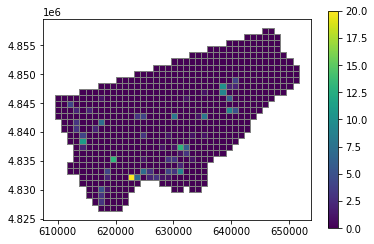

In [19]:
preview.plot(
    column='centrelines_feature_code_major_arterial_ramp_count',
    edgecolor='gray',
    legend=True
)

#### collisions

Bin collision features and counts:

In [20]:
name = 'collisions'
data = read_data(f'{dist_folder}/clean-datasets/{name}.geojson')

for size, grid in allgrids.items():
    
    # Only process if dataset file not created
    file = Path(f'{dist_folder}/by-dataset-{size}/geogrid_to_{name}.geojson')
    if not file.is_file() or force:

        # Start processing
        timer = Timer(f'{name} ({size})', 'spatial binning')
        timer.start()

        # Spatial join to grid
        join = grid.sjoin(data, predicate='intersects')

        # Agg cols by grid
        group = join.groupby(join.index)
        dtstats = [s for s in genstats if s != 'sum']
        agg = group.agg({
            'collisions_month': [mode],
            'collisions_day_of_month': [mode] + dtstats,
            'collisions_day_of_week': [mode],
            'collisions_year': [mode] + dtstats,
            'collisions_hour': [mode] + dtstats,
            'collisions_fatalities': genstats,
            'collisions_injury': genstats,
            'collisions_ftr': genstats,
            'collisions_pd': genstats,
        })

        # Rename agg cols
        agg.columns = ['_'.join(c).strip() for c in agg.columns]

        # Count freq
        freq = []
        for c in ['collisions_month', 'collisions_day_of_month', 'collisions_day_of_week', 'collisions_year', 'collisions_hour']:

            # Get possible unique values in col
            round = False
            if c == 'collisions_month':
                possible = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
            elif c == 'collisions_day_of_month':
                possible = [*range(1,32)]
                round = True
            elif c == 'collisions_day_of_week':
                possible = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
            elif c == 'collisions_hour':
                possible = [*range(0,24)]
                round = True
            else:
                possible = data[c].unique()

            # Count freq for each unique value
            f = group.apply(ucounts, c=c, possible=possible, round=round)

            # Rename freq cols
            f = format_cols(f)
            prefix = c.replace(f'{name}_', '')
            f.columns = [f'{name}_{prefix}_{c}_count' for c in f.columns]
            freq.append(f)

        # Combine count freq
        freq = pd.concat(freq, axis=1)
        freq.index = freq.index.get_level_values(0)

        # Agg counts
        counts = group.size()
        counts.name = f'{name}_count'

        # Add agg, freq, and counts to grid
        gdf = grid.join(agg)
        gdf = gdf.join(freq)
        gdf = gdf.join(counts)
        gdf[f'{name}_count'] = gdf[f'{name}_count'].fillna(0)

        # Save by dataset
        gdf.to_file(file)

        # Save by variable
        save_vars(gdf, size)

        # End processing
        timer.end()

    else:
        print(f'Skipping {file} - already binned ({datetime.now()})')

Processing collisions (10) - spatial binning (2022-02-18 23:47:25.645745)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed collisions (10) - spatial binning (2022-02-18 23:47:29.027759) [Elapsed: 0:00:03.382014]
Processing collisions (20) - spatial binning (2022-02-18 23:47:29.027984)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed collisions (20) - spatial binning (2022-02-18 23:47:35.679743) [Elapsed: 0:00:06.651757]
Processing collisions (40) - spatial binning (2022-02-18 23:47:35.679987)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed collisions (40) - spatial binning (2022-02-18 23:47:54.331228) [Elapsed: 0:00:18.651240]
Processing collisions (60) - spatial binning (2022-02-18 23:47:54.331466)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed collisions (60) - spatial binning (2022-02-18 23:48:30.728009) [Elapsed: 0:00:36.396541]
Processing collisions (80) - spatial binning (2022-02-18 23:48:30.728259)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed collisions (80) - spatial binning (2022-02-18 23:49:31.022077) [Elapsed: 0:01:00.293815]
Processing collisions (100) - spatial binning (2022-02-18 23:49:31.022366)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed collisions (100) - spatial binning (2022-02-18 23:51:00.134120) [Elapsed: 0:01:29.111751]


Preview results of spatial binning `collisions`:

In [21]:
preview = gpd.read_file(f'{dist_folder}/by-dataset-40/geogrid_to_collisions.geojson')
preview = preview[preview['collisions_fatalities_mean'] > 0]
preview

,collisions_month_mode,collisions_day_of_month_mode,collisions_day_of_month_mean,collisions_day_of_month_min,collisions_day_of_month_max,collisions_day_of_month_median,collisions_day_of_month_var,collisions_day_of_month_skew,collisions_day_of_month_std,collisions_day_of_month_sem,...,collisions_hour_16_count,collisions_hour_17_count,collisions_hour_18_count,collisions_hour_19_count,collisions_hour_20_count,collisions_hour_21_count,collisions_hour_22_count,collisions_hour_23_count,collisions_count,geometry
78,February,17,14.834821,1.0,31.0,15.0,70.766316,0.130670,8.412272,0.562069,...,11.0,9.0,14.0,13.0,8.0,6.0,3.0,8.0,224.0,"POLYGON ((610605.320 4843216.528, 610605.320 4..."
80,July,10,15.294118,1.0,31.0,15.0,74.520833,0.101150,8.632545,0.507797,...,39.0,25.0,17.0,11.0,2.0,5.0,4.0,0.0,289.0,"POLYGON ((610605.320 4845320.228, 610605.320 4..."
107,June,23,15.758958,1.0,31.0,16.0,79.716681,-0.001405,8.928420,0.360322,...,39.0,55.0,59.0,38.0,26.0,29.0,19.0,11.0,614.0,"POLYGON ((611657.170 4841112.829, 611657.170 4..."
108,November,3,14.932939,1.0,31.0,15.0,74.521186,0.141172,8.632565,0.383386,...,31.0,38.0,29.0,22.0,16.0,15.0,8.0,8.0,507.0,"POLYGON ((611657.170 4842164.679, 611657.170 4..."
111,May,16,15.683333,1.0,31.0,16.0,74.337514,0.036279,8.621921,0.497787,...,26.0,33.0,18.0,18.0,12.0,1.0,11.0,9.0,300.0,"POLYGON ((611657.170 4845320.228, 611657.170 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1139,May,2,15.574074,1.0,31.0,16.0,81.181378,-0.031587,9.010071,0.866994,...,7.0,11.0,6.0,9.0,1.0,4.0,1.0,1.0,108.0,"POLYGON ((646368.214 4850579.477, 646368.214 4..."
1140,March,17,15.797710,1.0,31.0,16.0,69.633251,0.017173,8.344654,0.515534,...,17.0,18.0,23.0,19.0,4.0,15.0,10.0,10.0,262.0,"POLYGON ((646368.214 4851631.327, 646368.214 4..."
1167,February,10,16.044776,1.0,30.0,16.0,72.313769,0.068342,8.503750,0.734612,...,4.0,14.0,8.0,6.0,8.0,2.0,3.0,5.0,134.0,"POLYGON ((647420.064 4847423.928, 647420.064 4..."
1168,February,28,15.250000,1.0,31.0,13.5,78.936567,0.194257,8.884625,1.077419,...,11.0,3.0,4.0,5.0,3.0,2.0,3.0,4.0,68.0,"POLYGON ((647420.064 4848475.778, 647420.064 4..."


<AxesSubplot:>

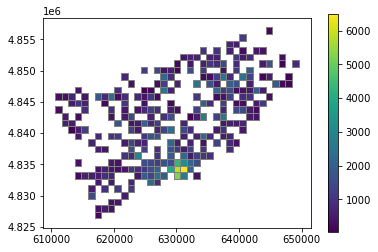

In [22]:
preview.plot(
    column='collisions_count',
    edgecolor='gray',
    legend=True
)

#### traffic

Bin counts of traffic features and counts:

In [23]:
name = 'traffic'
data = read_data(f'{dist_folder}/clean-datasets/{name}.geojson')

for size, grid in allgrids.items():

    # Only process if dataset file not created
    file = Path(f'{dist_folder}/by-dataset-{size}/geogrid_to_{name}.geojson')
    if not file.is_file() or force:

        # Start processing
        timer = Timer(f'{name} ({size})', 'spatial binning')
        timer.start()

        # Spatial join to grid
        join = grid.sjoin(data, predicate='intersects')

        # Agg cols by grid
        group = join.groupby(join.index)
        agg = group.agg({
            c: genstats for c in data.columns if c not in ['geometry', 'traffic_month', 'traffic_day_of_month', 'traffic_year']
        })

        # Rename agg cols
        agg.columns = ['_'.join(c).strip() for c in agg.columns]

        # Count freq
        freq = []
        for c in ['traffic_month', 'traffic_day_of_month', 'traffic_year']:

            # Get possible unique values in col
            if c == 'traffic_month':
                possible = [*range(1,32)]
            elif c == 'traffic_day_of_month':
                possible = [*range(1,32)]
            else:
                possible = data[c].unique()

            # Count freq for each unique value
            f = group.apply(ucounts, c=c, possible=possible)

            # Rename freq cols
            f = format_cols(f)
            prefix = c.replace(f'{name}_', '')
            f.columns = [f'{name}_{prefix}_{c}_count' for c in f.columns]
            freq.append(f)

        # Combine count freq
        freq = pd.concat(freq, axis=1)
        freq.index = freq.index.get_level_values(0)

        # Agg counts
        counts = group.size()
        counts.name = f'{name}_count'

        # Add agg, freq, and counts to grid
        gdf = grid.join(agg)
        gdf = gdf.join(freq)
        gdf = gdf.join(counts)
        gdf[f'{name}_count'] = gdf[f'{name}_count'].fillna(0)

        # Save by dataset
        gdf.to_file(file)

        # Save by variable
        save_vars(gdf, size)

        # End processing
        timer.end()

    else:
        print(f'Skipping {file} - already binned ({datetime.now()})')

Processing traffic (10) - spatial binning (2022-02-18 23:51:30.838091)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed traffic (10) - spatial binning (2022-02-18 23:51:44.935824) [Elapsed: 0:00:14.097736]
Processing traffic (20) - spatial binning (2022-02-18 23:51:44.936065)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed traffic (20) - spatial binning (2022-02-18 23:52:25.398153) [Elapsed: 0:00:40.462086]
Processing traffic (40) - spatial binning (2022-02-18 23:52:25.398390)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed traffic (40) - spatial binning (2022-02-18 23:54:45.494488) [Elapsed: 0:02:20.096096]
Processing traffic (60) - spatial binning (2022-02-18 23:54:45.494729)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed traffic (60) - spatial binning (2022-02-18 23:59:40.928468) [Elapsed: 0:04:55.433732]
Processing traffic (80) - spatial binning (2022-02-18 23:59:40.928849)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed traffic (80) - spatial binning (2022-02-19 00:08:04.277471) [Elapsed: 0:08:23.348621]
Processing traffic (100) - spatial binning (2022-02-19 00:08:04.277717)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed traffic (100) - spatial binning (2022-02-19 00:20:25.322899) [Elapsed: 0:12:21.045178]


Preview results of spatial binning `traffic`:

In [24]:
preview = gpd.read_file(f'{dist_folder}/by-dataset-40/geogrid_to_traffic.geojson')
preview = preview[preview['traffic_nb_cars_t_mean'] >= 0]
preview

,traffic_sb_cars_r_sum,traffic_sb_cars_r_mean,traffic_sb_cars_r_min,traffic_sb_cars_r_max,traffic_sb_cars_r_median,traffic_sb_cars_r_var,traffic_sb_cars_r_skew,traffic_sb_cars_r_std,traffic_sb_cars_r_sem,traffic_sb_cars_r_mad,...,traffic_year_2015_count,traffic_year_2010_count,traffic_year_2013_count,traffic_year_2019_count,traffic_year_2017_count,traffic_year_2014_count,traffic_year_2011_count,traffic_year_2018_count,traffic_count,geometry
17,1394.0,43.562500,20.0,89.0,36.5,418.834677,0.884834,20.465451,3.617815,17.175781,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,"POLYGON ((608501.620 4844268.378, 608501.620 4..."
48,653.0,5.101562,0.0,38.0,3.0,41.005352,2.755519,6.403542,0.565999,4.100708,...,0.0,32.0,0.0,0.0,0.0,0.0,32.0,0.0,128.0,"POLYGON ((609553.470 4844268.378, 609553.470 4..."
76,834.0,6.515625,0.0,26.0,6.0,36.550935,0.965694,6.045737,0.534373,4.806396,...,32.0,0.0,0.0,32.0,0.0,0.0,0.0,0.0,128.0,"POLYGON ((610605.320 4841112.829, 610605.320 4..."
77,1789.0,9.317708,0.0,85.0,3.0,223.537276,2.696950,14.951163,1.079007,9.785265,...,0.0,0.0,96.0,0.0,0.0,32.0,0.0,64.0,192.0,"POLYGON ((610605.320 4842164.679, 610605.320 4..."
79,323.0,2.523438,0.0,16.0,1.0,12.771100,1.854594,3.573668,0.315871,2.623779,...,0.0,0.0,0.0,0.0,0.0,0.0,64.0,0.0,128.0,"POLYGON ((610605.320 4844268.378, 610605.320 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201,7998.0,17.852679,0.0,74.0,14.0,301.450284,0.881303,17.362324,0.820293,14.142538,...,0.0,0.0,64.0,64.0,32.0,64.0,32.0,192.0,448.0,"POLYGON ((648471.914 4850579.477, 648471.914 4..."
1230,4344.0,16.968750,0.0,70.0,10.0,306.014706,1.020517,17.493276,1.093330,14.656006,...,0.0,32.0,0.0,32.0,0.0,0.0,0.0,128.0,256.0,"POLYGON ((649523.764 4848475.778, 649523.764 4..."
1231,2851.0,11.136719,0.0,53.0,5.0,183.059666,1.203134,13.529954,0.845622,11.283478,...,0.0,32.0,128.0,32.0,0.0,0.0,0.0,32.0,256.0,"POLYGON ((649523.764 4849527.627, 649523.764 4..."
1232,116.0,3.625000,1.0,8.0,3.5,4.951613,0.488331,2.225222,0.393367,1.875000,...,0.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0,32.0,"POLYGON ((649523.764 4850579.477, 649523.764 4..."


<AxesSubplot:>

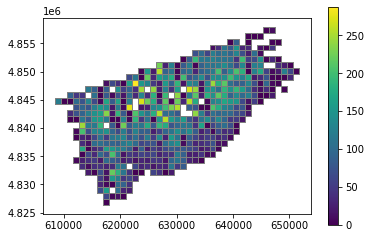

In [25]:
preview.plot(
    column='traffic_nb_cars_t_mean',
    edgecolor='gray',
    legend=True
)

#### watch_your_speed

Bin watch your speed program location counts and features:

In [26]:
name = 'watch_your_speed'
data = read_data(f'{dist_folder}/clean-datasets/{name}.geojson')

for size, grid in allgrids.items():
    
    # Only process if dataset file not created
    file = Path(f'{dist_folder}/by-dataset-{size}/geogrid_to_{name}.geojson')
    if not file.is_file() or force:

        # Start processing
        timer = Timer(f'{name} ({size})', 'spatial binning')
        timer.start()

        # Spatial join to grid
        join = grid.sjoin(data, predicate='intersects')

        # Agg cols by grid
        group = join.groupby(join.index)
        agg = group.agg({
            'wys_dir': [mode],
            'wys_min_speed': [mode] + genstats,
            'wys_speed_limit': [mode] + genstats,
        })

        # Rename agg cols
        agg.columns = ['_'.join(c).strip() for c in agg.columns]

        # Count freq
        freq = []
        for c in ['wys_dir', 'wys_min_speed', 'wys_speed_limit']:

            # Get possible unique values in col
            possible = data[c].unique()

            # Count freq for each unique value
            f = group.apply(ucounts, c=c, possible=possible)

            # Rename freq cols
            f = format_cols(f)
            prefix = c.replace(f'wys_', '')
            f.columns = [f'wys_{prefix}_{c}_count' for c in f.columns]
            freq.append(f)

        # Combine count freq
        freq = pd.concat(freq, axis=1)
        freq.index = freq.index.get_level_values(0)

        # Agg counts
        counts = group.size()
        counts.name = 'wys_count'

        # Add agg, freq, and counts to grid
        gdf = grid.join(agg)
        gdf = gdf.join(freq)
        gdf = gdf.join(counts)
        gdf['wys_count'] = gdf['wys_count'].fillna(0)

        # Save by dataset
        gdf.to_file(file)

        # Save by variable
        save_vars(gdf, size)

        # End processing
        timer.end()

    else:
        print(f'Skipping {file} - already binned ({datetime.now()})')

Processing watch_your_speed (10) - spatial binning (2022-02-19 00:20:30.703595)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed watch_your_speed (10) - spatial binning (2022-02-19 00:20:30.975080) [Elapsed: 0:00:00.271484]
Processing watch_your_speed (20) - spatial binning (2022-02-19 00:20:30.975315)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed watch_your_speed (20) - spatial binning (2022-02-19 00:20:31.709471) [Elapsed: 0:00:00.734152]
Processing watch_your_speed (40) - spatial binning (2022-02-19 00:20:31.709792)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed watch_your_speed (40) - spatial binning (2022-02-19 00:20:33.405850) [Elapsed: 0:00:01.696057]
Processing watch_your_speed (60) - spatial binning (2022-02-19 00:20:33.406079)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed watch_your_speed (60) - spatial binning (2022-02-19 00:20:36.303725) [Elapsed: 0:00:02.897644]
Processing watch_your_speed (80) - spatial binning (2022-02-19 00:20:36.303969)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed watch_your_speed (80) - spatial binning (2022-02-19 00:20:40.554275) [Elapsed: 0:00:04.250303]
Processing watch_your_speed (100) - spatial binning (2022-02-19 00:20:40.554521)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed watch_your_speed (100) - spatial binning (2022-02-19 00:20:46.388111) [Elapsed: 0:00:05.833588]


Preview results of spatial binning `watch_your_speed`:

In [27]:
preview = gpd.read_file(f'{dist_folder}/by-dataset-40/geogrid_to_watch_your_speed.geojson')
preview = preview[preview['wys_count'] > 0]
preview

,wys_dir_mode,wys_min_speed_mode,wys_min_speed_sum,wys_min_speed_mean,wys_min_speed_min,wys_min_speed_max,wys_min_speed_median,wys_min_speed_var,wys_min_speed_skew,wys_min_speed_std,...,wys_dir_none_count,wys_min_speed_5_count,wys_min_speed_30_count,wys_min_speed_20_count,wys_speed_limit_40_count,wys_speed_limit_50_count,wys_speed_limit_30_count,wys_speed_limit_60_count,wys_count,geometry
77,NB,5,70.0,17.500000,5.0,30.0,17.5,208.333333,0.000000,14.433757,...,0.0,2.0,2.0,0.0,4.0,0.0,0.0,0.0,4.0,"POLYGON ((610605.320 4842164.679, 610605.320 4..."
139,SB,5,100.0,10.000000,5.0,30.0,5.0,111.111111,1.778781,10.540926,...,0.0,8.0,2.0,0.0,8.0,2.0,0.0,0.0,10.0,"POLYGON ((612709.020 4842164.679, 612709.020 4..."
140,NB,30,170.0,18.888889,5.0,30.0,30.0,173.611111,-0.271052,13.176157,...,0.0,4.0,5.0,0.0,4.0,5.0,0.0,0.0,9.0,"POLYGON ((612709.020 4843216.528, 612709.020 4..."
141,NB,20,75.0,12.500000,5.0,20.0,12.5,67.500000,0.000000,8.215838,...,0.0,3.0,0.0,3.0,3.0,0.0,3.0,0.0,6.0,"POLYGON ((612709.020 4844268.378, 612709.020 4..."
142,NB,5,20.0,5.000000,5.0,5.0,5.0,0.000000,0.000000,0.000000,...,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,"POLYGON ((612709.020 4845320.228, 612709.020 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1107,EB,5,5.0,5.000000,5.0,5.0,5.0,NaN,NaN,NaN,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,"POLYGON ((645316.364 4849527.627, 645316.364 4..."
1138,NB,5,25.0,12.500000,5.0,20.0,12.5,112.500000,NaN,10.606602,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,2.0,"POLYGON ((646368.214 4849527.627, 646368.214 4..."
1139,WB,20,45.0,15.000000,5.0,20.0,20.0,75.000000,-1.732051,8.660254,...,0.0,1.0,0.0,2.0,1.0,0.0,2.0,0.0,3.0,"POLYGON ((646368.214 4850579.477, 646368.214 4..."
1140,WB,20,20.0,20.000000,20.0,20.0,20.0,NaN,NaN,NaN,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,"POLYGON ((646368.214 4851631.327, 646368.214 4..."


<AxesSubplot:>

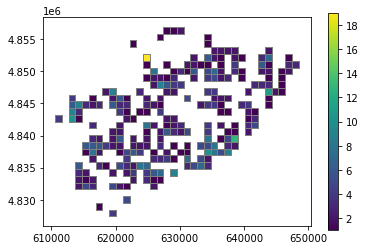

In [28]:
preview.plot(
    column='wys_count',
    edgecolor='gray',
    legend=True
)

#### schools

Bin school location counts and features:

In [29]:
name = 'schools'
data = read_data(f'{dist_folder}/clean-datasets/{name}.geojson')

for size, grid in allgrids.items():
    
    # Only process if dataset file not created
    file = Path(f'{dist_folder}/by-dataset-{size}/geogrid_to_{name}.geojson')
    if not file.is_file() or force:

        # Start processing
        timer = Timer(f'{name} ({size})', 'spatial binning')
        timer.start()

        # Spatial join to grid
        join = grid.sjoin(data, predicate='intersects')

        # Agg cols by grid
        group = join.groupby(join.index)
        agg = group.agg({
            'schools_level': [mode],
            'schools_type': [mode]
        })

        # Rename agg cols
        agg.columns = ['_'.join(c).strip() for c in agg.columns]

        # Count freq
        freq = []
        for c in ['schools_level', 'schools_type']:

            # Get possible unique values in col
            possible = data[c].unique()

            # Count freq for each unique value
            f = group.apply(ucounts, c=c, possible=possible)

            # Rename freq cols
            f = format_cols(f)
            prefix = c.replace(f'{name}_', '')
            f.columns = [f'{name}_{prefix}_{c}_count' for c in f.columns]
            freq.append(f)

        # Combine count freq
        freq = pd.concat(freq, axis=1)
        freq.index = freq.index.get_level_values(0)

        # Agg counts
        counts = group.size()
        counts.name = f'{name}_count'

        # Add agg, freq, and counts to grid
        gdf = grid.join(agg)
        gdf = gdf.join(freq)
        gdf = gdf.join(counts)
        gdf[f'{name}_count'] = gdf[f'{name}_count'].fillna(0)

        # Save by dataset
        gdf.to_file(file)

        # Save by variable
        save_vars(gdf, size)

        # End processing
        timer.end()

    else:
        print(f'Skipping {file} - already binned ({datetime.now()})')

Processing schools (10) - spatial binning (2022-02-19 00:20:46.738378)...
Processed schools (10) - spatial binning (2022-02-19 00:20:46.839664) [Elapsed: 0:00:00.101285]
Processing schools (20) - spatial binning (2022-02-19 00:20:46.839823)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed schools (20) - spatial binning (2022-02-19 00:20:47.120754) [Elapsed: 0:00:00.280929]
Processing schools (40) - spatial binning (2022-02-19 00:20:47.120988)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed schools (40) - spatial binning (2022-02-19 00:20:47.985276) [Elapsed: 0:00:00.864285]
Processing schools (60) - spatial binning (2022-02-19 00:20:47.985525)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed schools (60) - spatial binning (2022-02-19 00:20:49.396073) [Elapsed: 0:00:01.410545]
Processing schools (80) - spatial binning (2022-02-19 00:20:49.396301)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed schools (80) - spatial binning (2022-02-19 00:20:51.384524) [Elapsed: 0:00:01.988220]
Processing schools (100) - spatial binning (2022-02-19 00:20:51.384779)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed schools (100) - spatial binning (2022-02-19 00:20:53.885131) [Elapsed: 0:00:02.500349]


Preview results of spatial binning `watch_your_speed`:

In [30]:
preview = gpd.read_file(f'{dist_folder}/by-dataset-40/geogrid_to_schools.geojson')
preview = preview[preview['schools_count'] > 0]
preview

,schools_level_mode,schools_type_mode,schools_level_none_count,schools_type_private_count,schools_type_english_public_count,schools_type_english_separate_count,schools_type_none_count,schools_type_french_public_count,schools_type_french_separate_count,schools_type_university_count,schools_count,geometry
77,None,English Separate,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,"POLYGON ((610605.320 4842164.679, 610605.320 4..."
108,None,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,"POLYGON ((611657.170 4842164.679, 611657.170 4..."
110,None,English Separate,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,"POLYGON ((611657.170 4844268.378, 611657.170 4..."
131,None,Private,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"POLYGON ((612709.020 4833749.880, 612709.020 4..."
139,None,English Public,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,"POLYGON ((612709.020 4842164.679, 612709.020 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...
1199,None,English Public,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,3.0,"POLYGON ((648471.914 4848475.778, 648471.914 4..."
1200,None,English Public,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,"POLYGON ((648471.914 4849527.627, 648471.914 4..."
1201,None,English Public,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,"POLYGON ((648471.914 4850579.477, 648471.914 4..."
1231,None,English Public,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,"POLYGON ((649523.764 4849527.627, 649523.764 4..."


<AxesSubplot:>

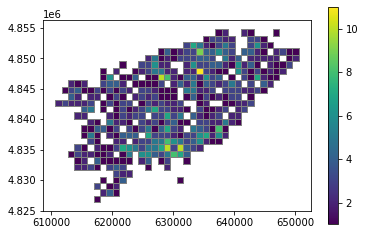

In [31]:
preview.plot(
    column='schools_count',
    edgecolor='gray',
    legend=True
)

#### childcare

Bin childcare location counts and features:

In [32]:
name = 'childcare'
data = read_data(f'{dist_folder}/clean-datasets/{name}.geojson')

for size, grid in allgrids.items():
    
    # Only process if dataset file not created
    file = Path(f'{dist_folder}/by-dataset-{size}/geogrid_to_{name}.geojson')
    if not file.is_file() or force:

        # Start processing
        timer = Timer(f'{name} ({size})', 'spatial binning')
        timer.start()

        # Spatial join to grid
        join = grid.sjoin(data, predicate='intersects')

        # Agg cols by grid
        group = join.groupby(join.index)
        agg = group.agg({
            'childcare_auspice': [mode],
            'childcare_bldg_type': [mode],
            'childcare_igspace': genstats,
            'childcare_tgspace': genstats,
            'childcare_pgspace': genstats,
            'childcare_kgspace': genstats,
            'childcare_sgspace': genstats,
            'childcare_totspace': genstats,
            'childcare_subsidy': genstats
        })

        # Rename agg cols
        agg.columns = ['_'.join(c).strip() for c in agg.columns]

        # Count freq
        freq = []
        for c in ['childcare_auspice', 'childcare_bldg_type']:

            # Get possible unique values in col
            possible = data[c].unique()

            # Count freq for each unique value
            f = group.apply(ucounts, c=c, possible=possible)

            # Rename freq cols
            f = format_cols(f)
            prefix = c.replace(f'{name}_', '')
            f.columns = [f'{name}_{prefix}_{c}_count' for c in f.columns]
            freq.append(f)

        # Combine count freq
        freq = pd.concat(freq, axis=1)
        freq.index = freq.index.get_level_values(0)

        # Agg counts
        counts = group.size()
        counts.name = f'{name}_count'

        # Add agg, freq, and counts to grid
        gdf = grid.join(agg)
        gdf = gdf.join(freq)
        gdf = gdf.join(counts)
        gdf[f'{name}_count'] = gdf[f'{name}_count'].fillna(0)

        # Save by dataset
        gdf.to_file(file)

        # Save by variable
        save_vars(gdf, size)

        # End processing
        timer.end()

    else:
        print(f'Skipping {file} - already binned ({datetime.now()})')

Processing childcare (10) - spatial binning (2022-02-19 00:20:54.178161)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed childcare (10) - spatial binning (2022-02-19 00:20:55.043134) [Elapsed: 0:00:00.864972]
Processing childcare (20) - spatial binning (2022-02-19 00:20:55.043370)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed childcare (20) - spatial binning (2022-02-19 00:20:57.673930) [Elapsed: 0:00:02.630557]
Processing childcare (40) - spatial binning (2022-02-19 00:20:57.674168)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed childcare (40) - spatial binning (2022-02-19 00:21:06.113766) [Elapsed: 0:00:08.439597]
Processing childcare (60) - spatial binning (2022-02-19 00:21:06.114004)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed childcare (60) - spatial binning (2022-02-19 00:21:22.024948) [Elapsed: 0:00:15.910942]
Processing childcare (80) - spatial binning (2022-02-19 00:21:22.025191)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed childcare (80) - spatial binning (2022-02-19 00:21:47.319288) [Elapsed: 0:00:25.294094]
Processing childcare (100) - spatial binning (2022-02-19 00:21:47.319522)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed childcare (100) - spatial binning (2022-02-19 00:22:22.914813) [Elapsed: 0:00:35.595288]


Preview results of spatial binning `watch_your_speed`:

In [33]:
preview = gpd.read_file(f'{dist_folder}/by-dataset-40/geogrid_to_childcare.geojson')
preview = preview[preview['childcare_count'] > 0]
preview

,childcare_auspice_mode,childcare_bldg_type_mode,childcare_igspace_sum,childcare_igspace_mean,childcare_igspace_min,childcare_igspace_max,childcare_igspace_median,childcare_igspace_var,childcare_igspace_skew,childcare_igspace_std,...,childcare_bldg_type_multi_human_services_facility_count,childcare_bldg_type_low_rise_apartment_count,childcare_bldg_type_synagogue_count,childcare_bldg_type_private_elementary_school_count,childcare_bldg_type_communityrec_centre_aocc_count,childcare_bldg_type_communityrec_centre_private_count,childcare_bldg_type_hospitalhealth_centre_count,childcare_bldg_type_community_health_centre_count,childcare_count,geometry
77,Non Profit Agency,Catholic Elementary School,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"POLYGON ((610605.320 4842164.679, 610605.320 4..."
108,Non Profit Agency,Community College/University,20.0,20.000000,20.0,20.0,20.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"POLYGON ((611657.170 4842164.679, 611657.170 4..."
131,Commercial Agency,Office Building,26.0,26.000000,26.0,26.0,26.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"POLYGON ((612709.020 4833749.880, 612709.020 4..."
138,Commercial Agency,Other,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"POLYGON ((612709.020 4841112.829, 612709.020 4..."
139,Non Profit Agency,Public Elementary School,20.0,6.666667,0.0,20.0,0.0,133.333333,1.732051,11.547005,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,"POLYGON ((612709.020 4842164.679, 612709.020 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199,Non Profit Agency,Public Elementary School,0.0,0.000000,0.0,0.0,0.0,0.000000,NaN,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,"POLYGON ((648471.914 4848475.778, 648471.914 4..."
1200,Commercial Agency,Other,6.0,6.000000,6.0,6.0,6.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"POLYGON ((648471.914 4849527.627, 648471.914 4..."
1201,Non Profit Agency,Public Elementary School,10.0,5.000000,0.0,10.0,5.0,50.000000,NaN,7.071068,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,"POLYGON ((648471.914 4850579.477, 648471.914 4..."
1231,Non Profit Agency,Public Elementary School,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"POLYGON ((649523.764 4849527.627, 649523.764 4..."


<AxesSubplot:>

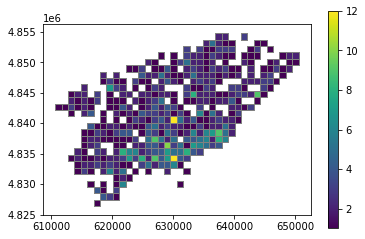

In [34]:
preview.plot(
    column='childcare_count',
    edgecolor='gray',
    legend=True
)

#### crime

Bin crime features and counts:

In [35]:
name = 'crime'
data = read_data(f'{dist_folder}/clean-datasets/{name}.geojson')

for size, grid in allgrids.items():
    
    # Only process if dataset file not created
    file = Path(f'{dist_folder}/by-dataset-{size}/geogrid_to_{name}.geojson')
    if not file.is_file() or force:

        # Start processing
        timer = Timer(f'{name} ({size})', 'spatial binning')
        timer.start()

        # Spatial join to grid
        join = grid.sjoin(data, predicate='intersects')

        # Agg cols by grid
        group = join.groupby(join.index)
        dtstats = [s for s in genstats if s != 'sum']
        agg = group.agg({
            'crime_division': [mode],
            'crime_premisetype': [mode],
            'crime_offence': [mode],
            'crime_reportedyear': [mode] + dtstats,
            'crime_reportedmonth': [mode],
            'crime_reportedday': [mode] + dtstats,
            'crime_reporteddayofyear': [mode] + dtstats,
            'crime_reporteddayofweek': [mode],
            'crime_reportedhour': [mode] + dtstats,
            'crime_occurrenceyear': [mode] + dtstats,
            'crime_occurrencemonth': [mode],
            'crime_occurrenceday': [mode] + dtstats,
            'crime_occurrencedayofyear': [mode] + dtstats,
            'crime_occurrencedayofweek': [mode],
            'crime_occurrencehour': [mode] + dtstats,
            'crime_mci': [mode],
            'crime_neighbourhood': [mode]
        })

        # Rename agg cols
        agg.columns = ['_'.join(c).strip() for c in agg.columns]

        # Count freq
        freq = []
        to_freq = [
            'crime_reportedmonth',
            'crime_occurrencemonth',
            'crime_reportedday',
            'crime_occurrenceday',
            'crime_reporteddayofweek',
            'crime_occurrencedayofweek',
            'crime_reportedhour',
            'crime_occurrencehour',
            'crime_neighbourhood',
            'crime_mci',
            'crime_offence',
            'crime_division'
        ]
        for c in to_freq:

            # Get possible unique values in col
            round = False
            if c in ['crime_reportedmonth', 'crime_occurrencemonth']:
                possible = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
            elif c in ['crime_reportedday', 'crime_occurrenceday']:
                possible = [*range(1,32)]
                round = True
            elif c in ['crime_reporteddayofweek', 'crime_occurrencedayofweek']:
                possible = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
            elif c in ['crime_reportedhour', 'crime_occurrencehour']:
                possible = [*range(0,24)]
                round = True
            else:
                possible = data[c].unique()

            # Count freq for each unique value
            f = group.apply(ucounts, c=c, possible=possible, round=round)

            # Rename freq cols
            f = format_cols(f)
            prefix = c.replace(f'{name}_', '')
            f.columns = [f'{name}_{prefix}_{c}_count' for c in f.columns]
            freq.append(f)

        # Combine count freq
        freq = pd.concat(freq, axis=1)
        freq.index = freq.index.get_level_values(0)

        # Agg counts
        counts = group.size()
        counts.name = f'{name}_count'

        # Add agg, freq, and counts to grid
        gdf = grid.join(agg)
        gdf = gdf.join(freq)
        gdf = gdf.join(counts)
        gdf[f'{name}_count'] = gdf[f'{name}_count'].fillna(0)

        # Save by dataset
        gdf.to_file(file)

        # Save by variable
        save_vars(gdf, size)

        # End processing
        timer.end()

    else:
        print(f'Skipping {file} - already binned ({datetime.now()})')

Processing crime (10) - spatial binning (2022-02-19 00:22:38.900704)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed crime (10) - spatial binning (2022-02-19 00:22:49.366250) [Elapsed: 0:00:10.465545]
Processing crime (20) - spatial binning (2022-02-19 00:22:49.366484)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed crime (20) - spatial binning (2022-02-19 00:23:14.967090) [Elapsed: 0:00:25.600604]
Processing crime (40) - spatial binning (2022-02-19 00:23:14.967325)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed crime (40) - spatial binning (2022-02-19 00:24:38.431115) [Elapsed: 0:01:23.463787]
Processing crime (60) - spatial binning (2022-02-19 00:24:38.431351)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed crime (60) - spatial binning (2022-02-19 00:27:34.472570) [Elapsed: 0:02:56.041217]
Processing crime (80) - spatial binning (2022-02-19 00:27:34.472817)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed crime (80) - spatial binning (2022-02-19 00:32:35.380933) [Elapsed: 0:05:00.908113]
Processing crime (100) - spatial binning (2022-02-19 00:32:35.381179)...


/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed crime (100) - spatial binning (2022-02-19 00:40:06.107176) [Elapsed: 0:07:30.725995]


Preview results of spatial binning `crime`:

In [36]:
preview = gpd.read_file(f'{dist_folder}/by-dataset-40/geogrid_to_crime.geojson')
preview = preview[preview['crime_count'] > 0]
preview

,crime_division_mode,crime_premisetype_mode,crime_offence_mode,crime_reportedyear_mode,crime_reportedyear_mean,crime_reportedyear_min,crime_reportedyear_max,crime_reportedyear_median,crime_reportedyear_var,crime_reportedyear_skew,...,crime_division_d51_count,crime_division_d13_count,crime_division_d23_count,crime_division_d53_count,crime_division_d33_count,crime_division_d41_count,crime_division_d54_count,crime_division_d42_count,crime_count,geometry
31,D11,House,Assault,2015,2018.000000,2015.0,2021.0,2018.0,18.000000,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,"POLYGON ((609553.470 4826386.931, 609553.470 4..."
32,NSA,Apartment,Assault,2017,2016.333333,2015.0,2017.0,2017.0,1.333333,-1.732051,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,"POLYGON ((609553.470 4827438.781, 609553.470 4..."
33,D12,House,Assault Bodily Harm,2014,2014.000000,2014.0,2014.0,2014.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"POLYGON ((609553.470 4828490.631, 609553.470 4..."
34,NSA,Apartment,Robbery - Home Invasion,2014,2014.000000,2014.0,2014.0,2014.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"POLYGON ((609553.470 4829542.481, 609553.470 4..."
35,NSA,Commercial,Robbery - Business,2019,2019.000000,2019.0,2019.0,2019.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"POLYGON ((609553.470 4830594.330, 609553.470 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1263,D43,House,Assault,2018,2016.000000,2014.0,2018.0,2016.0,5.333333,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,"POLYGON ((650575.614 4850579.477, 650575.614 4..."
1264,NSA,House,Assault,2016,2016.000000,2016.0,2016.0,2016.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"POLYGON ((650575.614 4851631.327, 650575.614 4..."
1265,NSA,Commercial,Robbery - Financial Institute,2020,2019.800000,2019.0,2020.0,2020.0,0.200000,-2.236068,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,"POLYGON ((650575.614 4852683.177, 650575.614 4..."
1266,D42,House,Assault Bodily Harm,2014,2017.500000,2014.0,2021.0,2017.5,24.500000,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,"POLYGON ((650575.614 4853735.027, 650575.614 4..."


<AxesSubplot:>

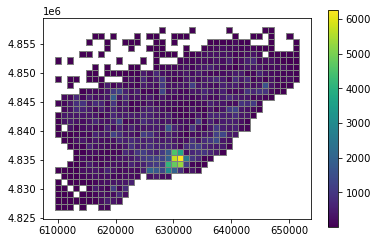

In [37]:
preview.plot(
    column='crime_count',
    edgecolor='gray',
    legend=True
)

### Combine Datasets

Combine processed datasets into one final dataset.

In [38]:
for size, grid in allgrids.items():
    
    # Get dataset files
    dfiles = Path(f'{dist_folder}/by-dataset-{size}').glob('*')
    dfiles = [f for f in dfiles if f.is_file() and f.suffix == '.geojson']
    
    # Combine if not exists
    file = Path(f'{dist_folder}/geogrid_to_{size}.geojson')
    if not file.is_file() or force:

        # Read each file and combine to grid
        out = read_data(f'{dist_folder}/base-grids/geogrid_to_{size}_base.geojson')
        out_timer = Timer(file, 'combining')
        out_timer.start()
        for f in dfiles:

            # Start processing
            timer = Timer(str(f), 'combining')
            timer.start()

            # Read dataset and drop unneeded columns
            data = read_data(f).drop('geometry', axis=1)

            # Combine dataset
            out = out.join(data)

            # End processing
            timer.end()

        # Save combined datasets
        out.to_file(file)
        out_timer.end()

    else:
        print(f'Skipping {file} - already combined ({datetime.now()})')

Processing ../tmp/dist/geogrid_to_10.geojson - combining (2022-02-19 00:40:09.307681)...
Processing ../tmp/dist/by-dataset-10/geogrid_to_wayfind.geojson - combining (2022-02-19 00:40:09.307764)...
Processed ../tmp/dist/by-dataset-10/geogrid_to_wayfind.geojson - combining (2022-02-19 00:40:09.397141) [Elapsed: 0:00:00.089373]
Processing ../tmp/dist/by-dataset-10/geogrid_to_transit_shelters.geojson - combining (2022-02-19 00:40:09.397296)...
Processed ../tmp/dist/by-dataset-10/geogrid_to_transit_shelters.geojson - combining (2022-02-19 00:40:09.407510) [Elapsed: 0:00:00.010214]
Processing ../tmp/dist/by-dataset-10/geogrid_to_fire_stations.geojson - combining (2022-02-19 00:40:09.407635)...
Processed ../tmp/dist/by-dataset-10/geogrid_to_fire_stations.geojson - combining (2022-02-19 00:40:09.416728) [Elapsed: 0:00:00.009094]
Processing ../tmp/dist/by-dataset-10/geogrid_to_religious.geojson - combining (2022-02-19 00:40:09.416830)...
Processed ../tmp/dist/by-dataset-10/geogrid_to_religious.

/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed ../tmp/dist/geogrid_to_10.geojson - combining (2022-02-19 00:41:00.486401) [Elapsed: 0:00:51.178718]
Processing ../tmp/dist/geogrid_to_20.geojson - combining (2022-02-19 00:41:00.504848)...
Processing ../tmp/dist/by-dataset-20/geogrid_to_wayfind.geojson - combining (2022-02-19 00:41:00.504910)...
Processed ../tmp/dist/by-dataset-20/geogrid_to_wayfind.geojson - combining (2022-02-19 00:41:00.523983) [Elapsed: 0:00:00.019072]
Processing ../tmp/dist/by-dataset-20/geogrid_to_transit_shelters.geojson - combining (2022-02-19 00:41:00.524099)...
Processed ../tmp/dist/by-dataset-20/geogrid_to_transit_shelters.geojson - combining (2022-02-19 00:41:00.542903) [Elapsed: 0:00:00.018803]
Processing ../tmp/dist/by-dataset-20/geogrid_to_fire_stations.geojson - combining (2022-02-19 00:41:00.543008)...
Processed ../tmp/dist/by-dataset-20/geogrid_to_fire_stations.geojson - combining (2022-02-19 00:41:00.561935) [Elapsed: 0:00:00.018927]
Processing ../tmp/dist/by-dataset-20/geogrid_to_religiou

/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed ../tmp/dist/geogrid_to_20.geojson - combining (2022-02-19 00:43:47.518089) [Elapsed: 0:02:47.013239]
Processing ../tmp/dist/geogrid_to_40.geojson - combining (2022-02-19 00:43:47.567857)...
Processing ../tmp/dist/by-dataset-40/geogrid_to_wayfind.geojson - combining (2022-02-19 00:43:47.567935)...
Processed ../tmp/dist/by-dataset-40/geogrid_to_wayfind.geojson - combining (2022-02-19 00:43:47.620887) [Elapsed: 0:00:00.052951]
Processing ../tmp/dist/by-dataset-40/geogrid_to_transit_shelters.geojson - combining (2022-02-19 00:43:47.620954)...
Processed ../tmp/dist/by-dataset-40/geogrid_to_transit_shelters.geojson - combining (2022-02-19 00:43:47.674140) [Elapsed: 0:00:00.053186]
Processing ../tmp/dist/by-dataset-40/geogrid_to_fire_stations.geojson - combining (2022-02-19 00:43:47.674208)...
Processed ../tmp/dist/by-dataset-40/geogrid_to_fire_stations.geojson - combining (2022-02-19 00:43:47.727833) [Elapsed: 0:00:00.053626]
Processing ../tmp/dist/by-dataset-40/geogrid_to_religiou

/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed ../tmp/dist/geogrid_to_40.geojson - combining (2022-02-19 00:54:00.972565) [Elapsed: 0:10:13.404707]
Processing ../tmp/dist/geogrid_to_60.geojson - combining (2022-02-19 00:54:01.119465)...
Processing ../tmp/dist/by-dataset-60/geogrid_to_wayfind.geojson - combining (2022-02-19 00:54:01.119561)...
Processed ../tmp/dist/by-dataset-60/geogrid_to_wayfind.geojson - combining (2022-02-19 00:54:01.232856) [Elapsed: 0:00:00.113292]
Processing ../tmp/dist/by-dataset-60/geogrid_to_transit_shelters.geojson - combining (2022-02-19 00:54:01.232950)...
Processed ../tmp/dist/by-dataset-60/geogrid_to_transit_shelters.geojson - combining (2022-02-19 00:54:01.343142) [Elapsed: 0:00:00.110190]
Processing ../tmp/dist/by-dataset-60/geogrid_to_fire_stations.geojson - combining (2022-02-19 00:54:01.343221)...
Processed ../tmp/dist/by-dataset-60/geogrid_to_fire_stations.geojson - combining (2022-02-19 00:54:01.451849) [Elapsed: 0:00:00.108627]
Processing ../tmp/dist/by-dataset-60/geogrid_to_religiou

/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed ../tmp/dist/geogrid_to_60.geojson - combining (2022-02-19 01:16:25.466904) [Elapsed: 0:22:24.347438]
Processing ../tmp/dist/geogrid_to_80.geojson - combining (2022-02-19 01:16:25.692160)...
Processing ../tmp/dist/by-dataset-80/geogrid_to_wayfind.geojson - combining (2022-02-19 01:16:25.692240)...
Processed ../tmp/dist/by-dataset-80/geogrid_to_wayfind.geojson - combining (2022-02-19 01:16:25.882358) [Elapsed: 0:00:00.190116]
Processing ../tmp/dist/by-dataset-80/geogrid_to_transit_shelters.geojson - combining (2022-02-19 01:16:25.882451)...
Processed ../tmp/dist/by-dataset-80/geogrid_to_transit_shelters.geojson - combining (2022-02-19 01:16:26.072030) [Elapsed: 0:00:00.189577]
Processing ../tmp/dist/by-dataset-80/geogrid_to_fire_stations.geojson - combining (2022-02-19 01:16:26.072130)...
Processed ../tmp/dist/by-dataset-80/geogrid_to_fire_stations.geojson - combining (2022-02-19 01:16:26.260062) [Elapsed: 0:00:00.187930]
Processing ../tmp/dist/by-dataset-80/geogrid_to_religiou

/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed ../tmp/dist/geogrid_to_80.geojson - combining (2022-02-19 01:55:32.034657) [Elapsed: 0:39:06.342496]
Processing ../tmp/dist/geogrid_to_100.geojson - combining (2022-02-19 01:55:32.344960)...
Processing ../tmp/dist/by-dataset-100/geogrid_to_wayfind.geojson - combining (2022-02-19 01:55:32.345073)...
Processed ../tmp/dist/by-dataset-100/geogrid_to_wayfind.geojson - combining (2022-02-19 01:55:32.631383) [Elapsed: 0:00:00.286309]
Processing ../tmp/dist/by-dataset-100/geogrid_to_transit_shelters.geojson - combining (2022-02-19 01:55:32.631463)...
Processed ../tmp/dist/by-dataset-100/geogrid_to_transit_shelters.geojson - combining (2022-02-19 01:55:32.917990) [Elapsed: 0:00:00.286525]
Processing ../tmp/dist/by-dataset-100/geogrid_to_fire_stations.geojson - combining (2022-02-19 01:55:32.918088)...
Processed ../tmp/dist/by-dataset-100/geogrid_to_fire_stations.geojson - combining (2022-02-19 01:55:33.203019) [Elapsed: 0:00:00.284929]
Processing ../tmp/dist/by-dataset-100/geogrid_to_

/Users/rrwen/Desktop/geogrid-to/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed ../tmp/dist/geogrid_to_100.geojson - combining (2022-02-19 02:54:34.801037) [Elapsed: 0:59:02.456076]


## Summary

In [39]:
gtimer.end()

Processed all datasets - preprocessing (2022-02-19 02:54:34.804057) [Elapsed: 3:09:40.850358]


Information for the final datasets:

In [40]:
# Read final datasets
files = [f'{dist_folder}/geogrid_to_{size}.geojson' for size in allgrids]
datasets = {Path(f).stem: read_data(f) for f in files}

# Create summary info
info = pd.DataFrame([df_info(df, name) for name, df in datasets.items()])
info_files = pd.DataFrame([file_info(name) for name in files])
summary = pd.concat([info, info_files], axis=1)

# Rearrange summary columns and display
summary['file'] = files
summary = summary.rename(columns={'url': 'raw_url'})
summary = summary[['dataset', 'file', 'created', 'modified', 'columns', 'rows', 'geometry', 'memory_usage', 'size']]
summary

,dataset,file,created,modified,columns,rows,geometry,memory_usage,size
0,geogrid_to_10,../tmp/dist/geogrid_to_10.geojson,2022-02-19 00:40:10.415612,2022-02-19 00:41:00.485003,1593,108,['Polygon'],1.3 MiB,6.4 MiB
1,geogrid_to_20,../tmp/dist/geogrid_to_20.geojson,2022-02-19 00:41:03.538320,2022-02-19 00:43:47.517783,1593,352,['Polygon'],4.3 MiB,20.7 MiB
2,geogrid_to_40,../tmp/dist/geogrid_to_40.geojson,2022-02-19 00:43:58.259153,2022-02-19 00:54:00.972190,1593,1302,['Polygon'],15.8 MiB,75.8 MiB
3,geogrid_to_60,../tmp/dist/geogrid_to_60.geojson,2022-02-19 00:54:24.193979,2022-02-19 01:16:25.466561,1593,2852,['Polygon'],34.7 MiB,165.0 MiB
4,geogrid_to_80,../tmp/dist/geogrid_to_80.geojson,2022-02-19 01:17:06.124470,2022-02-19 01:55:32.034267,1593,5002,['Polygon'],60.8 MiB,287.8 MiB
5,geogrid_to_100,../tmp/dist/geogrid_to_100.geojson,2022-02-19 01:56:33.094127,2022-02-19 02:54:34.800577,1593,7575,['Polygon'],92.1 MiB,434.3 MiB


The final dataset is also split by datasets for convenience:

In [19]:
all_summary = []

for size in allgrids:

    # Get files
    files = Path(f'{dist_folder}/by-dataset-{size}').glob('*')
    files = [f for f in files]

    # Read datasets
    datasets = {Path(f).stem.replace('geogrid_to_', ''): read_data(f) for f in files}

    # Create summary info
    info = pd.DataFrame([df_info(df, name) for name, df in datasets.items()])
    info_files = pd.DataFrame([file_info(name) for name in files])
    summary = pd.concat([info, info_files], axis=1)

    # Add supplymentary info
    sources = read_data(data_sources_file)
    sources = sources.rename(columns={'file': 'dataset'})
    sources = sources[sources['dataset'] != f'{study_area_dataset}.geojson']
    sources['dataset'] = [k for k in datasets]
    summary = pd.merge(
        summary,
        sources,
        on='dataset',
        how='left'
    )

    # Format columns
    summary['file'] = [f for f in files]
    summary['grid_size'] = size
    summary = summary.rename(columns={'url': 'raw_url'})
    
    # Add summary to all summary
    all_summary.append(summary)

# Display summary
all_summary = pd.concat(all_summary)
all_summary = all_summary[['dataset', 'file', 'created', 'modified', 'columns', 'rows', 'geometry', 'memory_usage', 'size', 'source', 'source_url', 'raw_url']]
display(HTML(all_summary.to_html(render_links=True)))

,dataset,file,created,modified,columns,rows,geometry,memory_usage,size,source,source_url,raw_url
0,wayfind,../tmp/dist/by-dataset-10/geogrid_to_wayfind.geojson,2022-02-18 23:45:00.053627,2022-02-18 23:45:00.065069,2,108,['Polygon'],1.8 KiB,40.8 KiB,City of Toronto Open Data Portal,https://open.toronto.ca/dataset/toronto-centreline-tcl/,https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/ba71b78e-464b-46dd-8185-a0d249fe4857
1,transit_shelters,../tmp/dist/by-dataset-10/geogrid_to_transit_shelters.geojson,2022-02-18 23:45:00.022342,2022-02-18 23:45:00.033107,2,108,['Polygon'],1.8 KiB,41.8 KiB,Toronto Police Service Public Safety Data Portal,https://data.torontopolice.on.ca/datasets/TorontoPS::traffic-collisions-asr-t-tbl-001/about,https://opendata.arcgis.com/api/v3/datasets/2a36d61277a84c3eb9d0beebef4c023d_0/downloads/data?format=geojson&spatialRefId=4326
2,fire_stations,../tmp/dist/by-dataset-10/geogrid_to_fire_stations.geojson,2022-02-18 23:44:59.440326,2022-02-18 23:44:59.451275,2,108,['Polygon'],1.8 KiB,41.4 KiB,City of Toronto Open Data Portal,https://open.toronto.ca/dataset/traffic-volumes-at-intersections-for-all-modes/,https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/0ffadfc9-b017-44df-a1b1-905591e54caa
3,religious,../tmp/dist/by-dataset-10/geogrid_to_religious.geojson,2022-02-18 23:45:00.419990,2022-02-18 23:45:00.430761,2,108,['Polygon'],1.8 KiB,41.0 KiB,City of Toronto Open Data Portal,https://open.toronto.ca/dataset/automated-speed-enforcement-locations/,https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/e25e9460-a0e8-469c-b9fb-9a4837ac6c1c?format=geojson&projection=4326
4,art,../tmp/dist/by-dataset-10/geogrid_to_art.geojson,2022-02-18 23:45:00.326820,2022-02-18 23:45:00.337822,2,108,['Polygon'],1.8 KiB,40.3 KiB,City of Toronto Open Data Portal,https://open.toronto.ca/dataset/school-safety-zone-watch-your-speed-program-locations/,https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/4e2221b9-da3a-4ef8-b8eb-17e95b7abaa0?format=geojson&projection=4326
5,childcare,../tmp/dist/by-dataset-10/geogrid_to_childcare.geojson,2022-02-19 00:20:54.569402,2022-02-19 00:20:54.985033,128,108,['Polygon'],108.1 KiB,581.8 KiB,City of Toronto Open Data Portal,https://open.toronto.ca/dataset/red-light-cameras/,https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/b57a31a1-5ee6-43e3-bfb9-206ebe93066d?format=geojson&projection=4326
6,renewables,../tmp/dist/by-dataset-10/geogrid_to_renewables.geojson,2022-02-18 23:44:59.467082,2022-02-18 23:44:59.478334,2,108,['Polygon'],1.8 KiB,41.1 KiB,City of Toronto Open Data Portal,https://open.toronto.ca/dataset/police-facility-locations/,https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/4afc3c66-5614-466a-b714-e8d6336fc6d3?format=geojson&projection=4326
7,watch_your_speed,../tmp/dist/by-dataset-10/geogrid_to_watch_your_speed.geojson,2022-02-19 00:20:30.890687,2022-02-19 00:20:30.950575,43,108,['Polygon'],36.4 KiB,174.4 KiB,City of Toronto Open Data Portal,https://open.toronto.ca/dataset/ambulance-station-locations/,https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/e49245ba-395c-46bf-bcf8-22fc7024d649?format=geojson&projection=4326
8,culture,../tmp/dist/by-dataset-10/geogrid_to_culture.geojson,2022-02-18 23:45:00.368413,2022-02-18 23:45:00.379228,2,108,['Polygon'],1.8 KiB,40.8 KiB,City of Toronto Open Data Portal,https://open.toronto.ca/dataset/fire-hydrants/,https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/beaaa552-6338-4c81-95be-411e6cef6b89?format=geojson&projection=4326
9,litter,../tmp/dist/by-dataset-10/geogrid_to_litter.geojson,2022-02-18 23:45:00.290563,2022-02-18 23:45:00.301672,2,108,['Polygon'],1.8 KiB,40.7 KiB,City of Toronto Open Data Portal,https://open.toronto.ca/dataset/fire-station-locations/,https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/9d1b7352-32ce-4af2-8681-595ce9e47b6e?format=geojson&projection=4326
